In [2]:
import tensorflow as tf
tfkl = tf.keras.layers
import csv
import numpy as np
import pandas as pd
import os as os
import matplotlib.pyplot as plt
#from keras.layers import Input, Embedding, Flatten, Dense, BatchNormalization, Dropout, concatenate
#from keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [3]:
# load in hmd data
data = []
ages = []
countries = []
genders = []

with open("../data/Mx_1x1/hmd.csv", "r") as file:
    reader = csv.reader(file,delimiter=",")
    for row_index, row in enumerate(reader):
        if row_index == 0:
            print(row)
        if row_index >= 1:
            year, age, country, gender, rate = row
            year = int(year)
            try:
                age = int(age)
            except:
                age = -1
            if country not in countries:
                countries.append(country)
            country = countries.index(country)
            if gender not in genders:
                genders.append(gender)
            gender = genders.index(gender)
            try:
                rate = float(rate)
            except:
                rate = -1
            if rate > 1:
                rate = 1
            # truncating the ages as they do in the paper
            # this might lead to issues when calculating e0 later 
            if age != -1 and rate != -1 and age <= 99: 
                data.append([year, age, country, gender, rate])

data = np.array(data)

['Year', 'Age', 'Country', 'Gender', 'Mortality_rate']


In [4]:
# standardizing the hmd country codes to match the world bank country codes
countries[28] = 'NZL'
countries[12] = 'FRA'

In [5]:
wb_data = np.load("../data/wb_cleaned.npy")
wb_indicators = np.load("../data/wb_indicators.npy")
wb_countries = np.load("../data/wb_countries.npy")
wb_countries = wb_countries.tolist()

FileNotFoundError: [Errno 2] No such file or directory: '../data/wb_cleaned.npy'

In [ ]:
combined_data = []
excl_countries = ['TWN', 'GBRTENW', 'GBR_NIR', 'GBR_SCO']
for row in data:
    country = row[2]
    country_code = countries[int(country)]
    if(country_code in excl_countries):
        continue
    country_index = wb_countries.index(country_code)
    year_index = row[0] - 1961
    if(year_index < 0 or year_index > 60):
        continue
    features = wb_data[country_index, :, int(year_index)]
    combined_row = np.concatenate((row, features))
    combined_data.append(combined_row)

combined_data = np.array(combined_data)
    

In [1]:
combined_data.shape

NameError: name 'combined_data' is not defined

In [7]:
for i in range(combined_data.shape[1]):
    if i < 5:
        continue
    combined_data[:, i] = combined_data[:, i] / np.max(combined_data[:, i])

In [8]:
# set up training and test data using boolean vectors created with logical AND statement
training_index = np.logical_and(combined_data[:, 0] >= 1961, combined_data[:, 0] <= 1990)
training_data = combined_data[training_index, :]
test_index = np.logical_and(combined_data[:, 0] > 1990, combined_data[:, 0] <= 2000)
test_data = combined_data[test_index, :]

In [9]:
training_data = tf.convert_to_tensor(training_data)
test_data = tf.convert_to_tensor(test_data)
# cast tensor to type float32
training_data = tf.cast(training_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
num_train = training_data.shape[0]
num_test = test_data.shape[0]

In [10]:
test_data.shape



TensorShape([68000, 62])

In [11]:
# define function to fetch and process data entries from training or test data 
def get_data(index, mode):
    if mode == "train":
        # randomly selects index from training data between 0 and num_train
        rand_index = tf.random.uniform([],minval=0, maxval=num_train, dtype=tf.int32) 
        entry = training_data[rand_index, :]
    elif mode == "not_random":
        # selects specified index from test data 
        entry = test_data[index, :]
    else: 
        # for any other value of mode, randomly selects index from test
        rand_index = tf.random.uniform([],minval=0, maxval=num_test, dtype=tf.int32)
        entry = test_data[rand_index, :]
    year, age, country, gender, rate = entry[0], entry[1], entry[2], entry[3], entry[4]
    wb = entry[5:]
    year = (year - 1961)/50
    age = tf.cast(age, tf.int32)
    country = tf.cast(country, tf.int32)
    gender = tf.cast(gender, tf.int32)
    year = tf.reshape(year, [1])
    age = tf.reshape(age, [1])
    country = tf.reshape(country, [1])
    gender = tf.reshape(gender, [1])
    rate = tf.reshape(rate, [1])
    wb = tf.reshape(wb,[57])
    return (year, age, country, gender, wb), rate

In [12]:
def get_figure_data(year, country, gender):
    #index = np.logical_and(combined_data[:,0] == year, combined_data[:,1] == age, combined_data[:, 2] == country, combined_data[:, 3] == gender)
    
        indices = (combined_data[:, 0] == year) & \
                (combined_data[:, 2] == country) & \
                (combined_data[:, 3] == gender)

        entries = combined_data[indices, :]
        
        entries_data = []
        entries_rate = []
        for entry in entries:
                year, age, country, gender, rate = entry[0], entry[1], entry[2], entry[3], entry[4]
                wb = entry[5:]
                year = (year - 1961)/50
                age = tf.cast(age, tf.int32)
                country = tf.cast(country, tf.int32)
                gender = tf.cast(gender, tf.int32)
                year = tf.reshape(year, [1])
                age = tf.reshape(age, [1])
                country = tf.reshape(country, [1])
                gender = tf.reshape(gender, [1])
                rate = tf.reshape(rate, [1])
                wb = tf.reshape(wb,[1, 57])
                entries_data.append([year, age, country, gender, wb])
                entries_rate.append(rate)

        return entries_data, entries_rate

In [13]:
# use get_data function to set up training and test tensorflow datasets 
dataset_train = tf.data.Dataset.from_tensor_slices(np.arange(10000))
dataset_train = dataset_train.repeat()
dataset_train = dataset_train.map(lambda x: get_data(x, mode="train"), num_parallel_calls=4)
dataset_train = dataset_train.batch(256)
dataset_train = dataset_train.prefetch(buffer_size=512)

dataset_test = tf.data.Dataset.from_tensor_slices(np.arange(10000))
dataset_test = dataset_test.repeat()
dataset_test = dataset_test.map(lambda x: get_data(x, mode="test"), num_parallel_calls=4)
dataset_test = dataset_test.batch(256)
dataset_test = dataset_test.prefetch(buffer_size=512)

dataset_test2 = tf.data.Dataset.from_tensor_slices(np.arange(68000))
dataset_test2 = dataset_test2.map(lambda x: get_data(x, mode="not_random"), num_parallel_calls=4)
dataset_test2 = dataset_test2.batch(256)
dataset_test2 = dataset_test2.prefetch(buffer_size=512)

In [14]:
# defining inputs 
year = tfkl.Input(shape=(1,), dtype='float32', name='Year')
age =  tfkl.Input(shape=(1,), dtype='int32', name='Age')
country = tfkl.Input(shape=(1,), dtype='int32', name='Country')
gender = tfkl.Input(shape=(1,), dtype='int32', name='Gender')
wb = tfkl.Input(shape=(57,), dtype='float32', name='World Bank Features')

# defining embedding layers 
age_embed = tfkl.Embedding(input_dim=100, output_dim=5, input_length=1, name='Age_embed')(age)
age_embed = tfkl.Flatten()(age_embed)

gender_embed = tfkl.Embedding(input_dim=2, output_dim=5, input_length=1, name='Gender_embed')(gender)
gender_embed = tfkl.Flatten()(gender_embed)

country_embed = tfkl.Embedding(input_dim=38, output_dim=5, input_length=1, name='Country_embed')(country)
country_embed = tfkl.Flatten()(country_embed)

# create feature vector that concatenates all inputs 
x = tfkl.Concatenate()([year, age_embed, gender_embed, country_embed, wb])
x1 = x

# setting up middle layers 
x = tfkl.Dense(128, activation='tanh')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.05)(x)

x = tfkl.Dense(128, activation='tanh')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.05)(x)

x = tfkl.Dense(128, activation='tanh')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.05)(x)

x = tfkl.Dense(128, activation='tanh')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.05)(x)

# setting up output layer 
x = tfkl.Concatenate()([x1, x])
x = tfkl.Dense(128, activation='tanh')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.05)(x)
x = tfkl.Dense(1, activation='sigmoid', name='final')(x)

# creating the model 
model = tf.keras.Model(inputs=[year, age, country, gender, wb], outputs=[x])

In [15]:
# compiling the model
model.compile(loss='mse', optimizer='adam')

In [16]:
model.fit(dataset_train, steps_per_epoch=1000, validation_data=dataset_test, validation_steps=500, epochs=9, verbose=2)

Epoch 1/9
1000/1000 - 16s - loss: 0.0148 - val_loss: 0.0013 - 16s/epoch - 16ms/step
Epoch 2/9
1000/1000 - 15s - loss: 0.0017 - val_loss: 9.6633e-04 - 15s/epoch - 15ms/step
Epoch 3/9
1000/1000 - 13s - loss: 0.0012 - val_loss: 5.8007e-04 - 13s/epoch - 13ms/step
Epoch 4/9
1000/1000 - 13s - loss: 0.0010 - val_loss: 5.6497e-04 - 13s/epoch - 13ms/step
Epoch 5/9
1000/1000 - 12s - loss: 9.3550e-04 - val_loss: 5.4418e-04 - 12s/epoch - 12ms/step
Epoch 6/9
1000/1000 - 13s - loss: 8.4938e-04 - val_loss: 6.0245e-04 - 13s/epoch - 13ms/step
Epoch 7/9
1000/1000 - 14s - loss: 8.2414e-04 - val_loss: 5.8150e-04 - 14s/epoch - 14ms/step
Epoch 8/9
1000/1000 - 16s - loss: 8.0465e-04 - val_loss: 5.0687e-04 - 16s/epoch - 16ms/step
Epoch 9/9
1000/1000 - 14s - loss: 8.1203e-04 - val_loss: 5.1954e-04 - 14s/epoch - 14ms/step


In [17]:
use_samples = [] # 6 values representing the row indexes for 6 plots we want to create? 
predictions = []
j = 0
for sample in use_samples:
    samples_to_predict.append(dataset_test2[sample])

predictions = np.array(predictions)

In [18]:
i = 0
for input, output in dataset_test2:
    i += 1
    print(i)
    if i > 100:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


In [19]:
for i, country in enumerate(countries):
    print(f'country: {country} index: {i}')

country: AUS index: 0
country: AUT index: 1
country: BEL index: 2
country: BGR index: 3
country: BLR index: 4
country: CAN index: 5
country: CHE index: 6
country: CZE index: 7
country: DNK index: 8
country: ESP index: 9
country: EST index: 10
country: FIN index: 11
country: FRA index: 12
country: GBRTENW index: 13
country: GBR_NIR index: 14
country: GBR_SCO index: 15
country: GRC index: 16
country: HUN index: 17
country: IRL index: 18
country: ISL index: 19
country: ISR index: 20
country: ITA index: 21
country: JPN index: 22
country: LTU index: 23
country: LUX index: 24
country: LVA index: 25
country: NLD index: 26
country: NOR index: 27
country: NZL index: 28
country: POL index: 29
country: PRT index: 30
country: RUS index: 31
country: SVK index: 32
country: SVN index: 33
country: SWE index: 34
country: TWN index: 35
country: UKR index: 36
country: USA index: 37


In [ ]:
fig_data, fig_rate = get_figure_data(2017, 32, 0)
fig_rate = np.array(fig_rate)
fig_predictions = []
for age_row in fig_data:
    inputs = age_row[0], age_row[1], age_row[2], age_row[3], age_row[4]
    predictions = model(inputs)
    fig_predictions.append(predictions)
fig_predictions = np.array(fig_predictions)

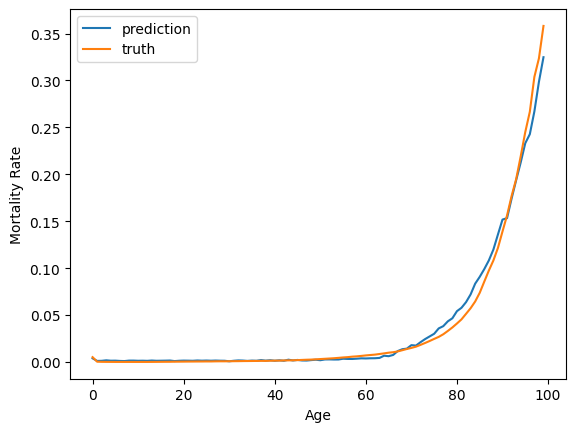

In [39]:
plt.figure()
plt.plot(fig_predictions[:, 0], label="prediction")
plt.plot(fig_rate[:, 0], label="truth")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Mortality Rate")
# plt.title()
plt.show()

In [ ]:
# residual plot
residuals = np.subtract(fig_predictions, fig_rate)

# Plotting the residuals
plt.scatter(fig_rate, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()